# Visual Odometry - KITTI Odometry Dataset

This notebook uses OpenCV to apply stereo depth estimation and multi-view geometry to attempt to track vehicle position through a sequence of the KITTI odometry dataset. A dataset handler class is provided to easily interact with the provided data and sensor calibration information. Useful functions are also provided to perform this basic example of visual odometry using the opencv-python package. 
While exploring this dataset, this notebook will review fundamental computer vision principles required to perform the task of stereo depth estimation and visual odometry, and demonstrate the implementation of those principles using numpy and OpenCV in Python.

These topics will include:

- The pinhole camera model
- Intrinsic and extrinsic camera parameters and matrices
- Projection matrices
- Rectified projection matrices
- Projective geometry
- 3D tranformations
- Disparity and depth estimation from stereo
- Image Feature detection/description/matching
- Pose estimation from Perspective n Point (PnP) algorithm using RANSAC

In [122]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import cv2

In [123]:
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', matplotlib.__version__)
print('OpenCV', cv2.__version__)

NumPy 1.23.3
Pandas 1.4.4
Matplotlib 3.7.2
OpenCV 4.8.0


## Data Exploration

In [124]:
#exploring dataset contents
dataset_path ="..\dataset"
sequence_path = os.path.join(dataset_path, "sequences", "00") #sequence: 00
gt_path = os.path.join(dataset_path, "poses", "00")

print("contents of the dataset directory: ",os.listdir(dataset_path))
print("contents of the ground truth directory", os.listdir(gt_path))
print("contents of the sequence: 00 directory", os.listdir(sequence_path))


contents of the dataset directory:  ['poses', 'sequences']
contents of the ground truth directory ['00.txt']
contents of the sequence: 00 directory ['calib.txt', 'image_0', 'image_1', 'times.txt', 'velodyne']


![SNOWFALL](kitti_schematic.png)

In [125]:
#exploring ground truth data
gt_data_path = os.path.join(gt_path, "00.txt")
gt_poses = pd.read_csv(gt_data_path, delimiter=' ', header=None)
print('Shape of position dataframe:', gt_poses.shape)
gt_poses.head()

Shape of position dataframe: (4541, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043680e-12,2.326809e-11,5.551115e-17,9.043683e-12,1.000000,2.392370e-10,3.330669e-16,2.326810e-11,2.392370e-10,1.000000,-4.440892e-16
1,0.999998,5.272628e-04,-2.066935e-03,-4.690294e-02,-5.296506e-04,0.999999,-1.154865e-03,-2.839928e-02,2.066324e-03,1.155958e-03,0.999997,8.586941e-01
2,0.999991,1.048972e-03,-4.131348e-03,-9.374345e-02,-1.058514e-03,0.999997,-2.308104e-03,-5.676064e-02,4.128913e-03,2.312456e-03,0.999989,1.716275e+00
3,0.999980,1.566466e-03,-6.198571e-03,-1.406429e-01,-1.587952e-03,0.999993,-3.462706e-03,-8.515762e-02,6.193102e-03,3.472479e-03,0.999975,2.574964e+00
4,0.999964,2.078471e-03,-8.263498e-03,-1.874858e-01,-2.116664e-03,0.999987,-4.615826e-03,-1.135202e-01,8.253797e-03,4.633149e-03,0.999955,3.432648e+00


In [126]:
print('First ground truth pose:')
first_pose = np.asarray(gt_poses.iloc[0]).reshape((3,4)).round(2)
first_pose

First ground truth pose:


array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1., -0.]])

In [127]:
#loading csv data to numpy array
num_frames = len(gt_poses)
gt = np.zeros((num_frames, 3, 4)) 

for i in range(num_frames):
    gt[i,:,:] = np.array(gt_poses.iloc[i]).reshape((3, 4))

In [128]:
#inspecting the first few vehicle poses
camera_origin_HC = np.array([0,0,0,1])
for i in range(8):
    print(f"Pose {i}",gt[i].dot(camera_origin_HC).round(2))

Pose 0 [ 0.  0. -0.]
Pose 1 [-0.05 -0.03  0.86]
Pose 2 [-0.09 -0.06  1.72]
Pose 3 [-0.14 -0.09  2.57]
Pose 4 [-0.19 -0.11  3.43]
Pose 5 [-0.23 -0.14  4.29]
Pose 6 [-0.28 -0.17  5.15]
Pose 7 [-0.33 -0.2   6.01]


In [129]:
#exploring timing data
times_path = os.path.join(sequence_path, "times.txt")
times = pd.read_csv(times_path, delimiter=' ', header=None)
times.head() #notice FPS is around 10 

,0
0,0.000000
1,0.103736
2,0.207338
3,0.311075
4,0.414692


In [187]:
#general info regarding sequence 00
print("Number of Frames: ", num_frames)
fps = 10
print("Frames per Second: ", fps)
seq_time = (num_frames / fps) / 60 #in minutes
print("Total Sequence Time: ", round(seq_time, 2), "mins")

Number of Frames:  4541
Frames per Second:  10
Total Sequence Time:  7.57 mins


In [131]:
#to enable interactivity
#%matplotlib ipympl

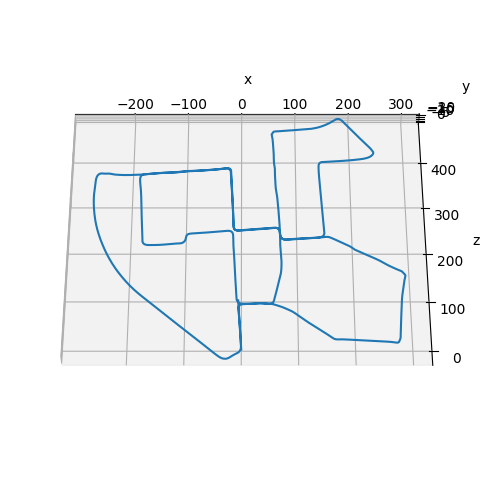

In [132]:
#visualizing sequence 00 (ground truth)
x_crds = gt[:, :, 3][:, 0]
y_crds = gt[:, :, 3][:, 1]
z_crds = gt[:, :, 3][:, 2]

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((np.ptp(x_crds), np.ptp(y_crds), np.ptp(z_crds)))
ax.plot(x_crds, y_crds, z_crds)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-40, azim=270)

In [133]:
#%matplotlib inline

<class 'numpy.ndarray'>


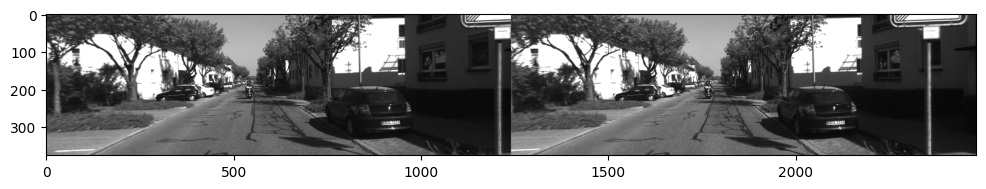

In [134]:
#taking a quick look on a sample image
sample_img_L = cv2.imread(os.path.join(sequence_path, "image_0", "000000.png"))
sample_img_R = cv2.imread(os.path.join(sequence_path, "image_1", "000000.png"))

print(type(sample_img_L))

plt.figure(figsize=(12,6))
plt.imshow(np.hstack((sample_img_L, sample_img_R)))


exploring the calibration file and point out the rectified projection matrix shit and how to invert them back to normal and would we like to do that

- Rectified Projection Matrices:
    - Distinction between global and local coordinate frames for the odometry problem vs the imaging problem

    - Regular vs. Rectified Configuration and what's the point?
    
    - is the rectified configuration invertable?

In [135]:
#loading calibration data
calib_path = os.path.join(sequence_path, "calib.txt")
calib = pd.read_csv(calib_path, delimiter=' ', header=None, index_col=0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


In [136]:
# P0 is the projection matrix of the left grayscale camera
P0 = np.array(calib.loc['P0:']).reshape((3,4))
P0

array([[718.856 ,   0.    , 607.1928,   0.    ],
       [  0.    , 718.856 , 185.2157,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

In [137]:
# Decomposing a projection matrix with OpenCV
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k1, r1, t1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
t1 = t1 / t1[3]
print('Intrinsic Matrix:')
print(k1)
print('Rotation Matrix:')
print(r1)
print('Translation Vector:')
print(t1.round(4))

Intrinsic Matrix:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[[ 0.5372]
 [ 0.    ]
 [-0.    ]
 [ 1.    ]]


In [138]:
R_t = np.hstack([r1, t1[:3]])
# Now to consider transform the origin of the global frame (0, 0, 0, 1)
R_t.dot(camera_origin_HC).round(4).reshape(-1,1)

array([[ 0.5372],
       [ 0.    ],
       [-0.    ]])

In [139]:
T_HC = np.vstack([R_t, camera_origin_HC])
T_HC_inv = np.linalg.inv(T_HC)
print('Homogeneous transformation matrix:')
print(T_HC.round(4))
print('Inverted homogeneous transformation matrix:')
print(T_HC_inv.round(4))

Homogeneous transformation matrix:
[[ 1.      0.      0.      0.5372]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.      1.     -0.    ]
 [ 0.      0.      0.      1.    ]]
Inverted homogeneous transformation matrix:
[[ 1.      0.      0.     -0.5372]
 [ 0.      1.      0.     -0.    ]
 [ 0.      0.      1.      0.    ]
 [ 0.      0.      0.      1.    ]]


## Dataset Handling

In [140]:
class Dataset_Handler():
    def __init__(self, sequence):
        #setting up directory paths
        self.dataset_path ="..\dataset"
        self.sequence_path = os.path.join(dataset_path, "sequences", sequence) #sequence: 00
        self.gt_data_path = os.path.join(dataset_path, "poses", sequence, sequence + ".txt")
        self.imgs_L_path = os.path.join(self.sequence_path, "image_0")
        self.imgs_R_path = os.path.join(self.sequence_path, "image_1")
        self.lidar_path = os.path.join(self.sequence_path, "velodyne")

        #fetch file names to iterate through
        self.img_L_files = os.listdir(self.imgs_L_path)
        self.img_R_files = os.listdir(self.imgs_R_path)
        self.Lidar_pcs = os.listdir(self.lidar_path) #lidar point clouds

        #fetching calibration matrices
        self.calib_path = os.path.join(self.sequence_path, "calib.txt")
        calib = pd.read_csv(self.calib_path, delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4)) #greyscale left camera
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4)) #greyscale right camera
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4)) #velodyne to left camera transformation

        #loading sample data to experiment with, without messing up generator iterator
        self.sample_img_L0 = cv2.imread(os.path.join(self.imgs_L_path, self.img_L_files[0]), 0)
        self.sample_img_L1 = cv2.imread(os.path.join(self.imgs_L_path, self.img_L_files[1]), 0)
        self.sample_img_R = cv2.imread(os.path.join(self.imgs_R_path, self.img_R_files[0]), 0)
        self.sample_pc = np.fromfile(os.path.join(self.lidar_path, self.Lidar_pcs[0]), dtype=np.float32, count = -1).reshape((-1,4))
        
        #setting up general dataset information
        self.num_frames = len(self.img_L_files)
        self.img_height = self.sample_img_L0.shape[0]
        self.img_width = self.sample_img_L0.shape[1]

        #setting up ground truth data
        gt_poses = pd.read_csv(self.gt_data_path, delimiter=' ', header=None)
        self.gt = np.zeros((self.num_frames, 3, 4)) 

        for i in range(self.num_frames):
            self.gt[i,:,:] = np.array(gt_poses.iloc[i]).reshape((3, 4))

        #resetting generator iterator
        self.reset_frames()
    def reset_frames(self):
        self.img_L = (cv2.imread(os.path.join(self.imgs_L_path, name_L) , 0)
                      for name_L in self.img_L_files)
        self.img_R = (cv2.imread(os.path.join(self.imgs_R_path, name_R) , 0)
                for name_R in self.img_R_files)
        self.pcs = (np.fromfile(os.path.join(self.lidar_path, name_pc), dtype=np.float32, count = -1).reshape((-1,4))
                    for name_pc in self.Lidar_pcs)
        

In [141]:
handler = Dataset_Handler('00')

## Stereopsis

 We will attempt to track the pose of the vehicle using depth maps derived from stereopsis, then using visual odometry of the left camera to track motion at scale.

 Theoretically, we can derive relative rotation and translation between frames without needing structure information. As the process of estimating The Essential Matrix disentagled structure from motion.

 But this estimate will only be upto a projective transform. We will have a relative and unitless reconstruction, not a metric one.

 Incorporating depth information is a way for providing a metric reconstruction.

In [142]:
def compute_disparity_map(img_L, img_R, matcher='bm'):
    #disparity map is computer for the left image of the stereo pair

    #stereo matcher hyper-parameters
    sad_window = 6
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    num_channels = 1 #greyscale

    #setting up stereo matcher
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * num_channels * (block_size ** 2),
                                        P2 = 32 * num_channels * (block_size ** 2),
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    
    disp_map = matcher.compute(img_L, img_R).astype(np.float32)/16

    return disp_map

In [143]:
#loading data for experimentation
img_L0 = handler.sample_img_L0
img_L1 = handler.sample_img_L1
img_R0 = handler.sample_img_R
pc_0 = handler.sample_pc

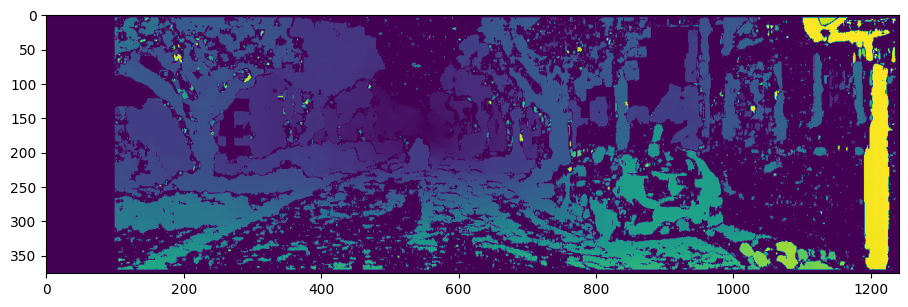

In [144]:
#compute disparity using StereoBM
disp_map_BM = compute_disparity_map(img_L0, img_R0, matcher='bm')
plt.figure(figsize=(11,7))
plt.imshow(disp_map_BM);

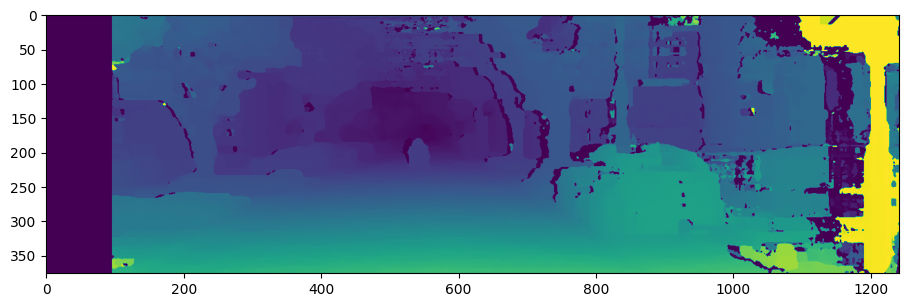

In [145]:
#compute disparity using stereoSGBM
disp_map_SGBM = compute_disparity_map(img_L0, img_R0, matcher='sgbm')
plt.figure(figsize=(11,7))
plt.imshow(disp_map_SGBM);

SGBM is generally slower than BM but produces more contiguous and smooth disparity maps, with less gaps in information

We can see that there is a gap of the left side of the image where the right camera did not have matching information. This will lead us to filter this gap out for downstream tasks to prevent useless computations

In [146]:
def decompose_proj_mat(p):

    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [147]:
def compute_depth_map(disp_left, k_left, t_left, t_right):
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    b = t_right[0] - t_left[0] #right - left since projection matrix is rectified
        
    # Avoid numerical instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [148]:
k_L, r_L, t_L = decompose_proj_mat(handler.P0)
k_R, r_R, t_R = decompose_proj_mat(handler.P1)

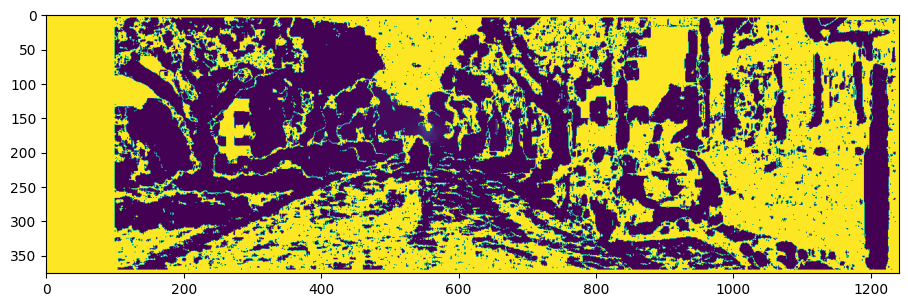

In [149]:
depth_map_BM = compute_depth_map(disp_map_BM, k_L, t_L, t_R)
plt.figure(figsize=(11,7))
plt.imshow(depth_map_BM);

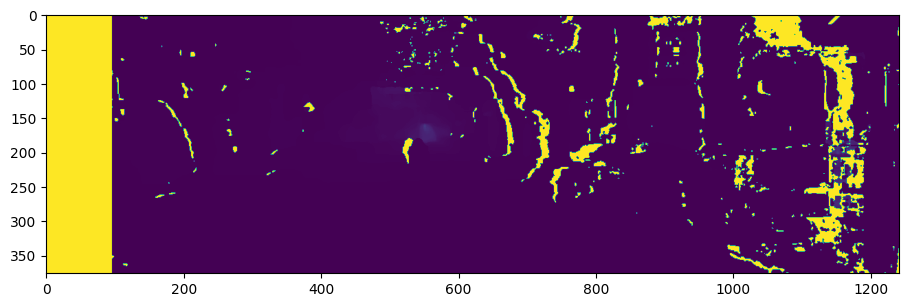

In [150]:
depth_map_SGBM = compute_depth_map(disp_map_SGBM, k_L, t_L, t_R)
plt.figure(figsize=(11,7))
plt.imshow(depth_map_SGBM);

In [151]:
print(depth_map_SGBM[0][0])
print(depth_map_SGBM.max())

3861.447942459941
3861.447942459941


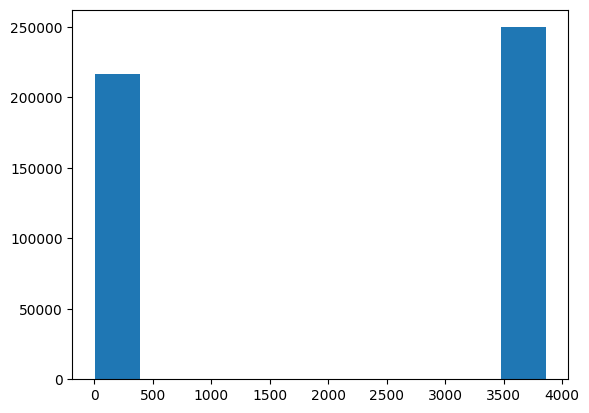

In [152]:
plt.hist(depth_map_BM.flatten());

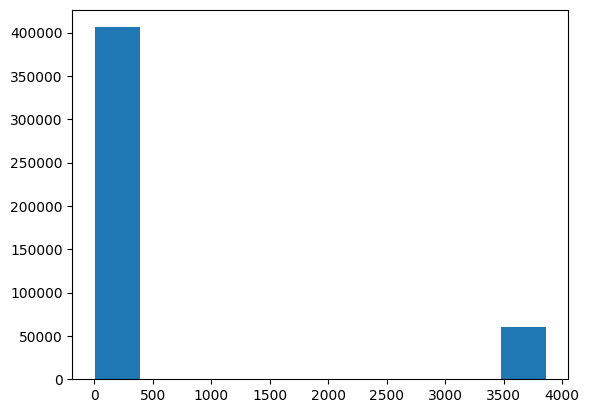

In [153]:
plt.hist(depth_map_SGBM.flatten());

In [154]:
#finding first non-max value to get dimensions of information gap
max_depth = depth_map_SGBM.max()
idx = 0 #first non-max value index
for i, pixel in enumerate(depth_map_SGBM[0]):
    if pixel < max_depth:
        idx = i
        break

idx

96

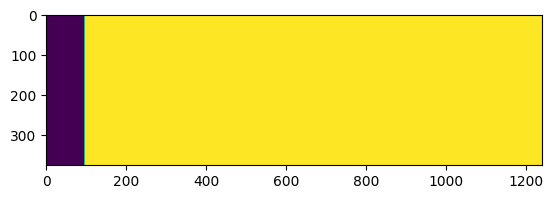

In [155]:
#constructing filteration mask
mask = np.zeros(img_L0.shape, dtype=np.uint8)
ymax = img_L0.shape[0]
xmax = img_L0.shape[1]
cv2.rectangle(mask, (idx,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);

In [156]:
def stereo_to_depth(img_L, img_R, P0, P1, matcher='bm'):
    #takes stereo pair of images and returns a depth map for the left camera.as well as a filtration mask

    def _compute_disparity_map(img_L, img_R, matcher='bm'):
        #disparity map is computer for the left image of the stereo pair

        #stereo matcher hyper-parameters
        sad_window = 6
        num_disparities = sad_window*16
        block_size = 11
        matcher_name = matcher
        num_channels = 1 #greyscale

        #setting up stereo matcher
        if matcher_name == 'bm':
            matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                        blockSize=block_size
                                        )
            
        elif matcher_name == 'sgbm':
            matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                            minDisparity=0,
                                            blockSize=block_size,
                                            P1 = 8 * num_channels * (block_size ** 2),
                                            P2 = 32 * num_channels * (block_size ** 2),
                                            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                        )
        
        disp_map = matcher.compute(img_L, img_R).astype(np.float32)/16

        return disp_map

    def _compute_depth_map(disp_left, k_left, t_left, t_right):
        # Get focal length of x axis for left camera
        f = k_left[0][0]
        
        # Calculate baseline of stereo pair
        b = t_right[0] - t_left[0] #right - left since projection matrix is rectified
            
        # Avoid numerical instability and division by zero
        disp_left[disp_left == 0.0] = 0.1
        disp_left[disp_left == -1.0] = 0.1
        
        # Make empty depth map then fill with depth
        depth_map = np.ones(disp_left.shape)
        depth_map = f * b / disp_left
    
        return depth_map
    
    def _construct_mask(depth_map):
        #finding first non-max value to get dimensions of information gap
        max_depth = depth_map.max()
        idx = 0 #first non-max value index
        for i, pixel in enumerate(depth_map[0]):
            if pixel < max_depth:
                idx = i
                break

        #constructing filteration mask
        mask = np.zeros(depth_map.shape, dtype=np.uint8)
        ymax = depth_map.shape[0]
        xmax = depth_map.shape[1]
        cv2.rectangle(mask, (idx,0), (xmax,ymax), (255), thickness = -1)

        return mask

    #compute disparity map
    disp_map = _compute_disparity_map(img_L, img_R, matcher)

    #decompose projection matrices
    k_L, _, t_L = decompose_proj_mat(P0)
    _, _, t_R = decompose_proj_mat(P1)
    #compute depth map
    depth_map = _compute_depth_map(disp_map, k_L, t_L, t_R)
    #construct filtration mask
    f_mask = _construct_mask(depth_map)
    
    return depth_map, f_mask

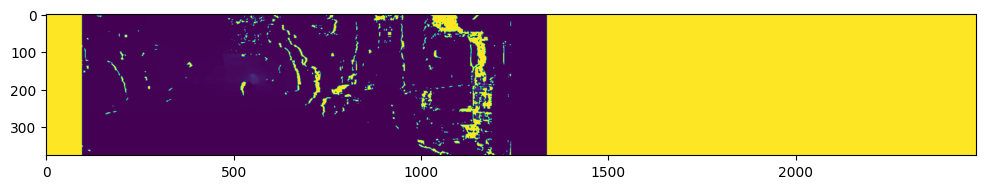

In [157]:
depth_map, f_mask = stereo_to_depth(img_L0, img_R0, handler.P0, handler.P1, matcher='sgbm')
plt.figure(figsize=(12,6))
plt.imshow(np.hstack(((depth_map/depth_map.max()), (f_mask/f_mask.max()))));

### Making Use of Lidar Data

#### Lidar Data Exploration

In [158]:
print('full pcloud shape', pc_0.shape)
trimmed_pcloud = pc_0[pc_0[:, 0] > 0]
print('trimmed pcloud shape', trimmed_pcloud.shape)

full pcloud shape (124668, 4)
trimmed pcloud shape (63141, 4)


In [159]:
handler.Tr.round(4)

array([[ 4.000e-04, -1.000e+00, -8.100e-03, -1.200e-02],
       [-7.200e-03,  8.100e-03, -9.999e-01, -5.400e-02],
       [ 1.000e+00,  5.000e-04, -7.200e-03, -2.922e-01]])

In [160]:
def pc_to_img(pc, imheight, imwidth, Tr, P0):
    '''
    Takes a pointcloud of shape Nx4 and projects it onto an image plane, first transforming
    the X, Y, Z coordinates of points to the camera frame with tranformation matrix Tr, then
    projecting them using camera projection matrix P0.
    '''

    #trimming points behind the car FOV
    pc = pc[pc[:, 0] > 0]

    #dropping reflectance information and converting to HC
    pc = np.hstack([pc[:, :3], np.ones(pc.shape[0]).reshape((-1,1))])

    #transform pointcloud into camera coordinate frame
    pc_2_Cam = Tr.dot(pc.T)
    
    #ignore any points behind the camera (probably redundant but just in case)
    pc_2_Cam = pc_2_Cam[:, pc_2_Cam[2] > 0]
    
    #extract depth
    depth = pc_2_Cam[2].copy()
    
    #project coordinates in camera frame to flat plane at Z=1 by dividing by Z (normalizing HC)
    pc_2_Cam /= pc_2_Cam[2]
    
    #converting to HC
    pc_2_Cam = np.vstack([pc_2_Cam, np.ones(pc_2_Cam.shape[1])])
    
    # Get pixel coordinates of X, Y, Z points in camera coordinate frame
    projection = P0.dot(pc_2_Cam)
    
    # Turn pixels into integers for indexing
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')

    # Limit pixel coordinates considered to those that fit on the image plane
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0)
                      )
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]

    #returning an image render of lidar depth values with the same dimensions as camera images
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        if u >= imwidth or u < 0:
            continue
        if v >= imheight or v < 0:
            continue
        render[v, u] = depth[j]

    return render


In [161]:
lidar_depth = pc_to_img(pc_0, 
                          handler.img_height,
                          handler.img_width,
                          handler.Tr,
                          handler.P0
                         )

lidar_depth.shape

(376, 1241)

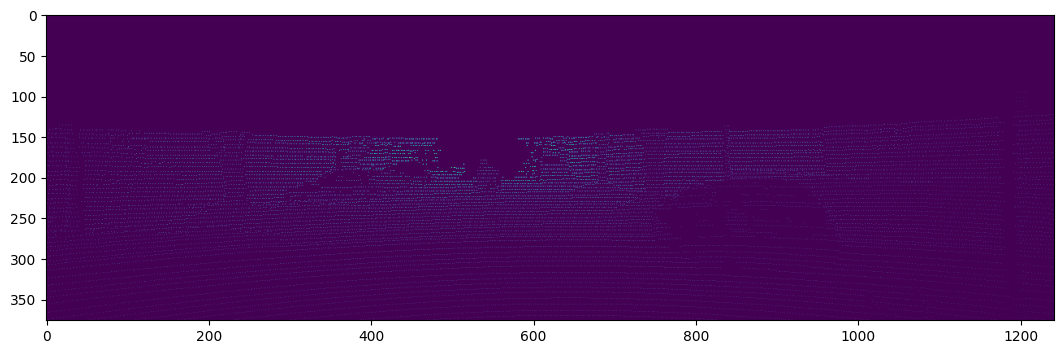

In [162]:
plt.figure(figsize=(13,5))
plt.imshow(lidar_depth);

In [163]:
for i, d in enumerate(depth_map[200:, :].flatten()):
    if lidar_depth[200:, :].flatten()[i] == 0:
        continue
    print('Stereo Depth:', d, 'Lidar Depth:', lidar_depth[200:, :].flatten()[i])
    if i > 1000:
        break

Stereo Depth: 24.040143190661475 Lidar Depth: 25.08251557273636
Stereo Depth: 36.99590898203592 Lidar Depth: 38.18529319193908
Stereo Depth: 37.67266341463414 Lidar Depth: 38.15661260397033
Stereo Depth: 37.67266341463414 Lidar Depth: 38.04491130916553
Stereo Depth: 38.13775802469135 Lidar Depth: 38.22929779114657
Stereo Depth: 38.37463850931676 Lidar Depth: 37.93287208133164
Stereo Depth: 38.61447999999999 Lidar Depth: 37.970212888663504
Stereo Depth: 38.61447999999999 Lidar Depth: 38.78230455441224
Stereo Depth: 39.10327088607594 Lidar Depth: 43.35304297366147
Stereo Depth: 52.80612649572648 Lidar Depth: 43.92954268130661
Stereo Depth: 56.681805504587146 Lidar Depth: 52.296451988896685
Stereo Depth: 57.20663703703703 Lidar Depth: 53.01673964440458
Stereo Depth: 57.20663703703703 Lidar Depth: 53.154098455093575
Stereo Depth: 57.741278504672884 Lidar Depth: 53.17143027237011
Stereo Depth: 57.741278504672884 Lidar Depth: 53.19275972156243
Stereo Depth: 57.741278504672884 Lidar Depth: 53

In [164]:
#determining the amount of image area that the lidar has given us depth information for
lidar_coverage = lidar_depth[lidar_depth > 0].size / lidar_depth.size
print(f"Lidar Coverage: {np.round(lidar_coverage, 2)*100} %")

Lidar Coverage: 4.0 %


#### Lidar Data Visualization

In [165]:
#to enable interactivity
#%matplotlib ipympl

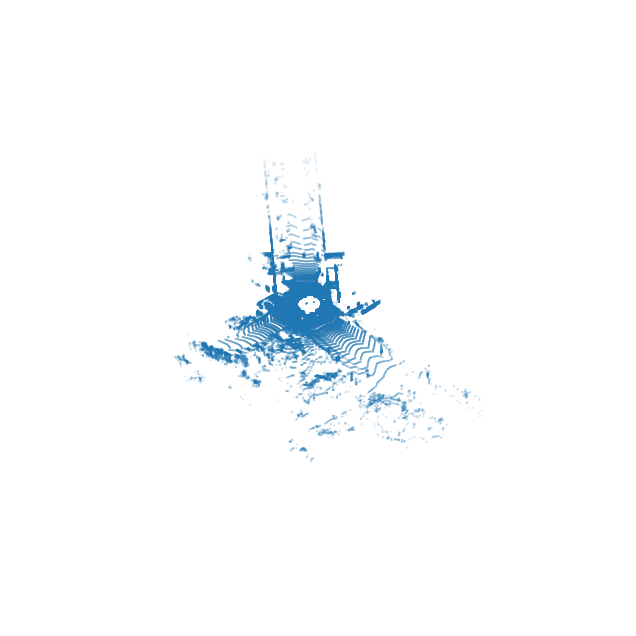

In [166]:
pc = handler.sample_pc
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

xs = pc[:, 0]#[::20]   # Uncomment if 3d plot runs too slow, takes every 20th point
ys = pc[:, 1]#[::20]
zs = pc[:, 2]#[::20]

ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
ax.scatter(xs, ys, zs, s=0.01)
ax.grid(False)
ax.axis('off')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=40, azim=180)

In [167]:
handler.reset_frames() #resetting generator

pc_frames = (pc_to_img(next(handler.pcs),
                                  handler.img_height,
                                  handler.img_width,
                                  handler.Tr,
                                  handler.P0)
                 for i in range(handler.num_frames))

stereo_l = handler.img_L
stereo_r = handler.img_R

In [168]:
for i in range(handler.num_frames // 20):
    img_l = next(stereo_l)
    img_r = next(stereo_r)
    
    disp = compute_disparity_map(img_l, img_r, matcher='sgbm')
    disp /= disp.max()
    #disp = 1 - disp
    disp = (disp*255).astype('uint8')
    #disp = cv2.applyColorMap(disp, cv2.COLORMAP_RAINBOW)
    pcloud = next(pc_frames)
    pcloud /= pcloud.max()
    pcloud = (pcloud*255).astype('uint8')
    
    cv2.imshow('camera', img_l)
    cv2.imshow('disparity', disp)
    cv2.imshow('lidar', pcloud)
    cv2.waitKey(1)
    
plt.close()
cv2.destroyAllWindows()

C:\Users\Mazen\AppData\Local\Temp\ipykernel_6128\43015917.py:11: RuntimeWarning: invalid value encountered in divide
  pcloud /= pcloud.max()


## Feature Extraction & Matching

In [169]:
def extract_features(image, detector='sift', mask=None):
    #Find keypoints and descriptors for the image
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [170]:
def match_features(des1, des2, matching='BF', detector='sift', k=2):
    
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

### Filtering Matched Based on Distance Ratios

We can see an informative graphic relating the quality of matches according to this metric below:

![SNOWFALL](lowe_ratio_test.png)

In [171]:
def filter_matches_distance(matches, dist_threshold):
    
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [172]:
def visualize_matches(image1, kp1, image2, kp2, match):
    
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

Number of matches before filtering: 3206
Number of matches after filtering: 446


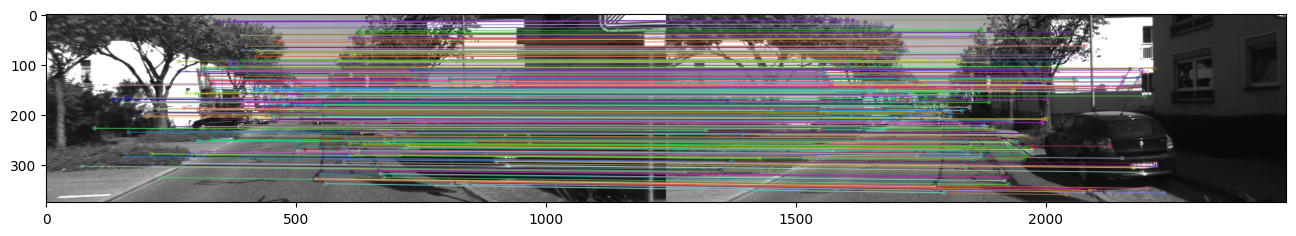

In [173]:
kp0, des0 = extract_features(img_L0, 'sift')
kp1, des1 = extract_features(img_L1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift')
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(img_L0, kp0, img_L1, kp1, matches)

In [174]:
def generate_matches(image1, image2, detector='sift', matching='BF', k=2, mask=None, dist_threshold=None):

    def _extract_features(image, detector='sift', mask=None):
        #Find keypoints and descriptors for the image
        if detector == 'sift':
            det = cv2.SIFT_create()
        elif detector == 'orb':
            det = cv2.ORB_create()
            
        kp, des = det.detectAndCompute(image, mask)
        
        return kp, des
    def _match_features(des1, des2, matching='BF', detector='sift', k=2):
    
        if matching == 'BF':
            if detector == 'sift':
                matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
            elif detector == 'orb':
                matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
            matches = matcher.knnMatch(des1, des2, k=k)
        elif matching == 'FLANN':
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
            matcher = cv2.FlannBasedMatcher(index_params, search_params)
            matches = matcher.knnMatch(des1, des2, k=k)
        
        matches = sorted(matches, key = lambda x:x[0].distance)

        return matches

    def _filter_matches_distance(matches, dist_threshold):
        
        filtered_match = []
        for m, n in matches:
            if m.distance <= dist_threshold*n.distance:
                filtered_match.append(m)

        return filtered_match
    
    #extract features from stereo pair
    kp0, des0 = _extract_features(image1, detector, mask)
    kp1, des1 = _extract_features(image2, detector, mask)

    #match features
    matches = _match_features(des0, des1, matching, detector)
    #filter features
    if dist_threshold is not None:
        matches = _filter_matches_distance(matches, dist_threshold)
    
    return kp0, kp1, matches

## Estimating Relative Motion

Establishing the relative rotation and translation between the two frames can be done by estimating and subsequently decomposing The Fundamental/Essential Matrix. 

The Fundamenta/Essential Matrixm computation disentagles structure from motion, and by effect, can reconstruct the scene without the need of structure information.

But this would be only accurate upto a projective transform, rendering our reconstruction unitless and lacking metric scale.

Instead,we use the PnP Algorithm instead. Its use of structure information makes it able to provide a metric reconstruction.

In [175]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):

    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

        # Extract depth information of query image at match points and build 3D positions
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
            #filter out missing depth information
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])

        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
        # Use PnP algorithm with RANSAC for robustness to outliers
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        #print('Number of inliers: {}/{} matched features'.format(len(inliers), len(match)))
        
        # Above function returns axis angle rotation representation rvec, use Rodrigues formula
        # to convert this to our desired format of a 3x3 rotation matrix
        rmat = cv2.Rodrigues(rvec)[0]

    else:
        # With no depth provided, use essential matrix decomposition instead. This is not really
        # very useful, since you will get a 3D motion tracking but the scale will be ambiguous
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

## Putting It All Together!

### NOTE:

The SolvePnPRansac() function computes a pose that relates points in the global
coordinate frame to the camera's pose. 

We used the camera's pose in the first image
as the global coordinate frame, reconstruct 3D positions of the features in the
image using stereo depth estimation, then find a pose which relates the camera in
the next frame to those 3D points. 

When tracking the vehicle pose over time, what we
actually want is to relate the points in the camera's coordinate frame to the global
frame, so we want the opposite (inverse) of the transformation matrix provided to us
by the SolvePnPRansac function. 

In [176]:
def visual_odometry(handler, lidar=False, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=False, depth_type='stereo', subset=None, plot=False):
    # Report methods being used to user
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), matching))

    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))
    if lidar:
        print('Improving stereo depth estimation with lidar data')

    if subset is not None:
        num_frames = subset
    else:
        num_frames = handler.num_frames
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')

    imheight = handler.img_height
    imwidth = handler.img_width

    # Establish Total homogeneous transformation matrix. First pose is identity    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]

    # Decompose left camera projection matrix to get intrinsic k matrix
    k_left, _, _ = decompose_proj_mat(handler.P0)

    handler.reset_frames()
    image_plus1 = next(handler.img_L)

    # Iterate through all frames of the sequence
    for i in range(num_frames - 1):
        start = datetime.datetime.now() #timing frame computation time

        # Get our stereo images for depth estimation
        
        image_left = image_plus1
        image_right = next(handler.img_R)
        # Get next frame in the left camera for visual odometry
        image_plus1 = next(handler.img_L)
        
        # Estimate depth if using stereo depth estimation (recommended)
        if depth_type == 'stereo':
            depth, f_mask = stereo_to_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
        # Otherwise use Essential Matrix decomposition (ambiguous scale)
        else:
            depth = None

        if lidar:
            pointcloud = next(handler.pcs)
            lidar_depth = pc_to_img(pointcloud, 
                                           imheight=imheight, 
                                           imwidth=imwidth, 
                                           Tr=handler.Tr, 
                                           P0=handler.P0)
            indices = np.where(lidar_depth > 0)
            depth[indices] = lidar_depth[indices]

        kp0, kp1, matches= generate_matches(image_left, image_plus1, detector, matching, k=2, mask=f_mask, dist_threshold=filter_match_distance)

        # Estimate motion between sequential images of the left camera
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)

        # Create blank homogeneous transformation matrix
        Tmat = np.eye(4)
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T

        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        # Place pose estimate in i+1 to correspond to the second image, which we estimated for
        trajectory[i+1, :, :] = T_tot[:3, :]
        # End the timer for the frame and report frame rate to user
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            ax.plot(xs, ys, zs, c='chartreuse')
            #plt.pause(1e-32)
    if plot:
        plt.close()

    return trajectory       

In [186]:
def calculate_error(ground_truth, estimated, error_type='mse'):
    # Find the number of frames in the estimated trajectory to compare with
    nframes_est = estimated.shape[0]
    
    def _get_mse(ground_truth, estimated):
        se = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)**2
        mse = se.mean()
        return mse
    
    def _get_mae(ground_truth, estimated):
        ae = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)
        mae = ae.mean()
        return mae
    
    mae = _get_mae(ground_truth, estimated)
    mse = _get_mse(ground_truth, estimated)
    rmse = np.sqrt(mse)
    return {'mae': mae,
            'rmse': rmse,
            'mse': mse}

### No LIDAR depth correction, StereoSGBM disparity matching

In [184]:
# Let's see how we do with no lidar, using the SGBM stereo matcher
start = datetime.datetime.now()
trajectory_nolidar_sgbm = visual_odometry(handler,
                                          lidar=False,
                                          filter_match_distance=0.5, 
                                          detector='sift',
                                          #matching='FLANN',
                                          stereo_matcher='sgbm',
                                          mask=True,     
                                          #subset=500,
                                          plot=False)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)

Generating disparities with StereoSGBM
Detecting features with SIFT and matching with BF
Filtering feature matches at threshold of 0.5*distance
Time to compute frame 1: 0:00:00.207307
Time to compute frame 2: 0:00:00.194691
Time to compute frame 3: 0:00:00.201828
Time to compute frame 4: 0:00:00.217851
Time to compute frame 5: 0:00:00.219904
Time to compute frame 6: 0:00:00.223102
Time to compute frame 7: 0:00:00.219111
Time to compute frame 8: 0:00:00.230473
Time to compute frame 9: 0:00:00.211945
Time to compute frame 10: 0:00:00.220175
Time to compute frame 11: 0:00:00.210370
Time to compute frame 12: 0:00:00.207883
Time to compute frame 13: 0:00:00.207864
Time to compute frame 14: 0:00:00.199631
Time to compute frame 15: 0:00:00.205369
Time to compute frame 16: 0:00:00.194600
Time to compute frame 17: 0:00:00.199685
Time to compute frame 18: 0:00:00.200001
Time to compute frame 19: 0:00:00.205829
Time to compute frame 20: 0:00:00.205902
Time to compute frame 21: 0:00:00.214284
Time

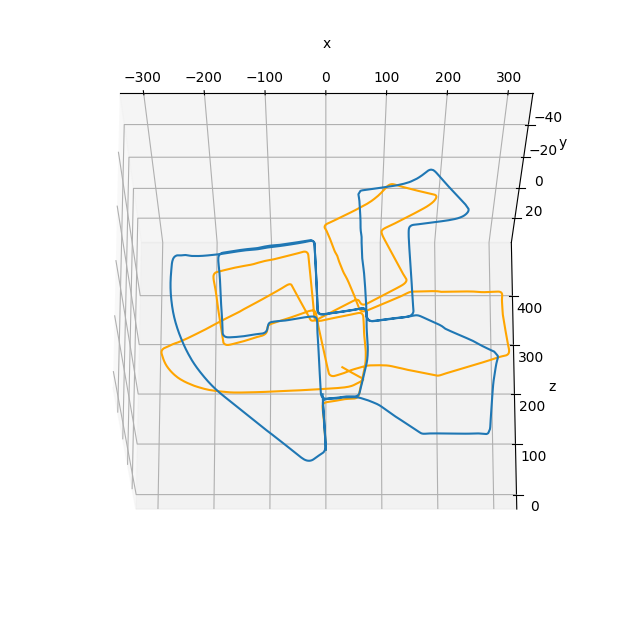

In [185]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(trajectory_nolidar_sgbm[:, :, 3][:, 0], 
        trajectory_nolidar_sgbm[:, :, 3][:, 1], 
        trajectory_nolidar_sgbm[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [180]:
calculate_error(handler.gt, trajectory_nolidar_sgbm)

{'mae': 26.07515062677966, 'rmse': 29.14723335608153, 'mse': 849.5612123138717}

### Brief Comments:

As you see, the algorithm managed to replicate the track contour quiet nicely, but it suffers from significant drift.

This is because the process, at the core, is dependent on the stereo depth estimates which suffers from significant errors.

This process can be imporved by a myriad of ways, but here are a few of them:

- Graph Pose Optimization (Loop Closure constraints)
- Sensor Fusion Algorithms (Kalman filter, particle filter,..) with other more accurate sensors (e.g. Lidar)
- Bundle adjustment
- Cross Validating with an existing map
